<a href="https://colab.research.google.com/github/iRahulPandey/medium-articles/blob/master/Imbalanced_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imbalanced Dataset
## Fraud Detection


1. Loading Data
2. Basic EDA
3. ML model
4. Trying different metrics
5. Different sampling techniques to deal with imbalanced data


## Loading Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import data
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df.head(n=2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


# Basic EDA

In [3]:
# check dataset
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


There exist number of features that shows hgh difference beteen 75th percentile and MAX value which indicates that there is quite a bit of outliers in the dataset. 

**To verify that one can use BoxPlot or use IQR**

IQR = third_quantile-first_quantile <br> 
Upper_limit = third_quantile + IQR*1.5 <br> 
Lower_limit = first_quantile - IQR*1.5 <br> 

Also, features are at different scale. All models using distance method or gradient descent must have features in same scale. So scaling is required.

Maybe dropping **Time** feature in this case is a better choice.

Features from v1-v28 are the result of a PCA Dimensionality reduction to protect user identities and sensitive features

In [4]:
# check null values
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

The dataset contains no Null values.

Now, let's check the column data type

In [5]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Drop Time column and use Class as label.

In [6]:
# drop time column
df.pop('Time')
df.head(n=2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [7]:
# remove duplicates
print(df.shape)
df.drop_duplicates(keep='first', inplace=True)
print(df.shape)

(284807, 30)
(275663, 30)


In [8]:
# check distinct labels
df['Class'].unique()

array([0, 1])

We have 2 distinct labels as expected

0. represents Normal Transaction - Not Fraud
1. represents Fraud

Now, Let's check the class distribution

In [9]:
# Check the frequency of each class
not_fraud, fraud = np.bincount(df['Class'])
total = not_fraud + fraud
print('Class distribution:\n    Total: {}\n    Negative: {} ({:.2f}% of total)\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, not_fraud, 100 * not_fraud / total, fraud, 100 * fraud / total))

Class distribution:
    Total: 275663
    Negative: 275190 (99.83% of total)
    Positive: 473 (0.17% of total)



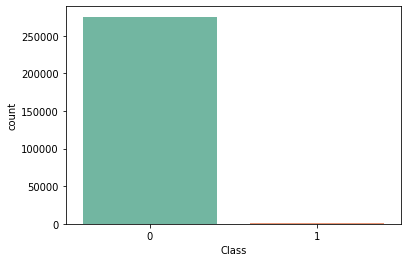

In [10]:
# plot graph
sns.countplot(x = 'Class', data=df, palette='Set2');

Extremely skewed dataset. Now let#s talk about a thing called Accuracy Paradox. We can't use accuracy in this case becuase any model without any training if only predicts majority class may result in accuracy of 99% which might not the reality.

In this case if we have Fraud (Positive) case and detected as Not-Fraud(Negative) i.e. False Negative can be very critical. However, on the other hand if we don't have fraud case and model predict fraud (False Positive), this case is also often not required because it means that due to false positive we might keep on asking costomers to verify which might be irritating for customers.

In this case we need to build a model that can minimize both FP and FN and hence f1 score can be the better metrics compared to accuracy.

NOw, lets check the correlation

In [ ]:
# some quick visualizatioon
numeric_columns = ['V1', 'V2', 'V3', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']

# pair plot to see how distribution looks
sns.pairplot(df[numeric_columns], hue='Class', palette='Set2');

Again this shows that features are not at same scale and also Amount column ranges between 0 to 10000 with some outliers.

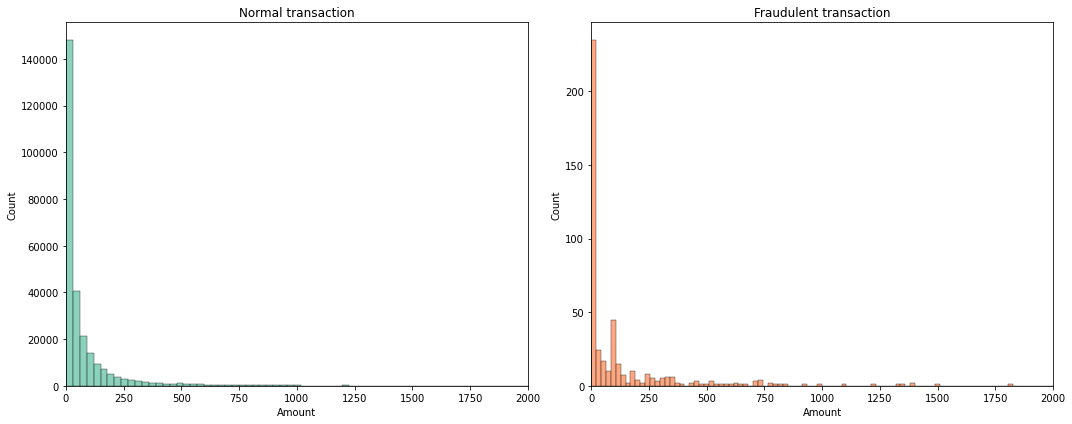

In [12]:
# check distribution of Amount
f, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw=dict(width_ratios=[4, 4]))
sns.histplot(df[(df.Amount<3000) & (df.Amount>0)& (df.Class==0)], x="Amount", bins=100, color='#66c2a4', ax=axs[0])
sns.histplot(df[(df.Amount<3000) & (df.Amount>0)& (df.Class==1)], x="Amount", bins=100, color='#fc8d59', ax=axs[1])
axs[0].set_xlim([0,2000])
axs[1].set_xlim([0,2000])
axs[0].set_title('Normal transaction')
axs[1].set_title('Fraudulent transaction')
f.tight_layout()

In [13]:
# convert Amount to log scale
# some amount is 0 and log is not defined at 0 hence add small amount
error = 0.001
df['log_Amount'] = np.log(df['Amount']+error)
df.head(n=2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,log_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.989913


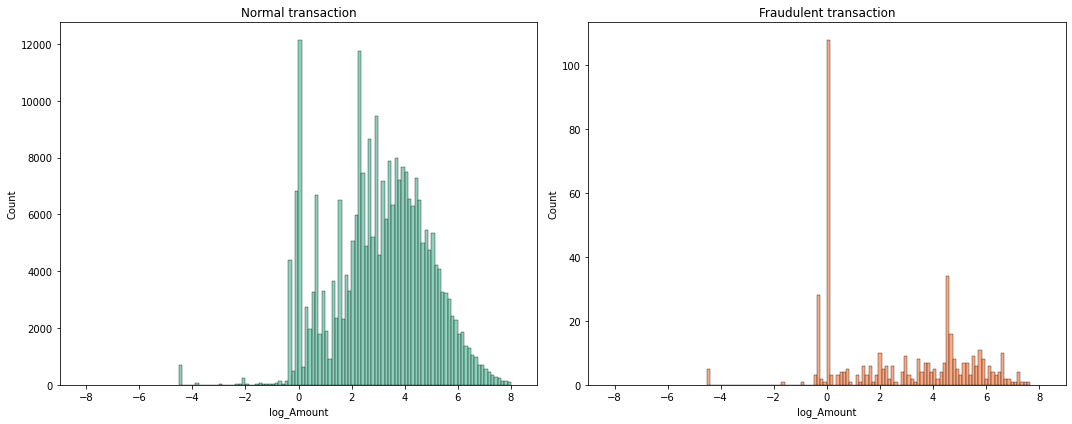

In [14]:
# check distribution of log_Amount
f, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw=dict(width_ratios=[4, 4]))
sns.histplot(df[(df.Amount<3000) & (df.Amount>0)& (df.Class==0)], x="log_Amount", bins=100, color='#66c2a4', ax=axs[0])
sns.histplot(df[(df.Amount<3000) & (df.Amount>0)& (df.Class==1)], x="log_Amount", bins=100, color='#fc8d59', ax=axs[1])
axs[0].set_xlim([-9,9])
axs[1].set_xlim([-9,9])
axs[0].set_title('Normal transaction')
axs[1].set_title('Fraudulent transaction')
f.tight_layout()

# Prepare Data

First we split data into train, test and validation dataset

Then we will do scaling og features followed by some jointplots 

In [15]:
from sklearn.model_selection import train_test_split

# copy data
df_copy = df.copy()

# remove the Amount
df_copy.pop('Amount')

# remove the Time
# df_copy.pop('Time')

# get label
labels = df_copy.pop('Class')

# get fearues
features = df_copy

# split data into train and test
X_train_ini, X_test, y_train_ini, y_test = train_test_split(features, labels, test_size=0.1, stratify = labels, random_state=0)

# split data into train and test
X_train, X_valid, y_train, y_valid = train_test_split(X_train_ini, y_train_ini, test_size=0.2, stratify = y_train_ini, random_state=0)

In [16]:
# Check the frequency of each class in splitted data for training data
train_not_fraud, train_fraud = np.bincount(y_train)
train_total = train_not_fraud + train_fraud
print('Training class distribution:\n    Total: {}\n    Negative: {} ({:.2f}% of total)\n    Positive: {} ({:.2f}% of total)\n'.format(
    train_total, train_not_fraud, 100 * train_not_fraud / train_total, train_fraud, 100 * train_fraud / train_total))

Training class distribution:
    Total: 198476
    Negative: 198135 (99.83% of total)
    Positive: 341 (0.17% of total)



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


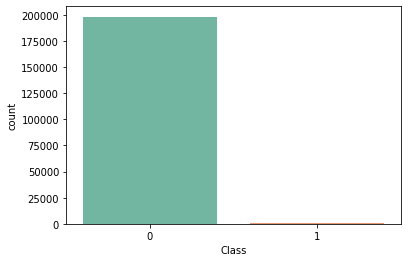

In [17]:
sns.countplot(y_train , palette='Set2');

In [18]:
# Check the frequency of each class in splitted data for validation data
valid_not_fraud, valid_fraud = np.bincount(y_valid)
valid_total = valid_not_fraud + valid_fraud
print('Validation class distribution:\n    Total: {}\n    Negative: {} ({:.2f}% of total)\n    Positive: {} ({:.2f}% of total)\n'.format(
    valid_total, valid_not_fraud, 100 * valid_not_fraud / valid_total, valid_fraud, 100 * valid_fraud / valid_total))

Validation class distribution:
    Total: 49620
    Negative: 49535 (99.83% of total)
    Positive: 85 (0.17% of total)



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


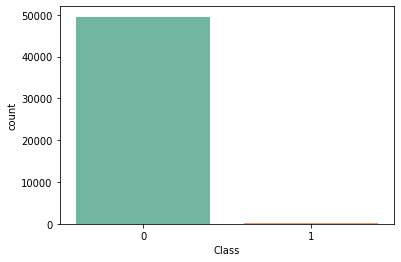

In [19]:
sns.countplot(y_valid , palette='Set2');

In [20]:
# Check the frequency of each class in splitted data for test data
test_not_fraud, test_fraud = np.bincount(y_test)
test_total = test_not_fraud + test_fraud
print('Testing class distribution:\n    Total: {}\n    Negative: {} ({:.2f}% of total)\n    Positive: {} ({:.2f}% of total)\n'.format(
    test_total, test_not_fraud, 100 * test_not_fraud / test_total, test_fraud, 100 * test_fraud / test_total))

Testing class distribution:
    Total: 27567
    Negative: 27520 (99.83% of total)
    Positive: 47 (0.17% of total)



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


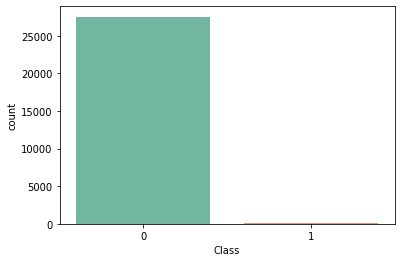

In [21]:
sns.countplot(y_test , palette='Set2');

In [22]:
# scale data
from sklearn.preprocessing import StandardScaler

# create object
scalar = StandardScaler()

# fit and transform train after that clip data
X_train_Scaled = np.clip(scalar.fit_transform(X_train), -5, 5)

# transform validate after that clip data
X_valid_Scaled = np.clip(scalar.transform(X_valid), -5, 5)

# transform test after that clip data
X_test_Scaled = np.clip(scalar.transform(X_test), -5, 5)

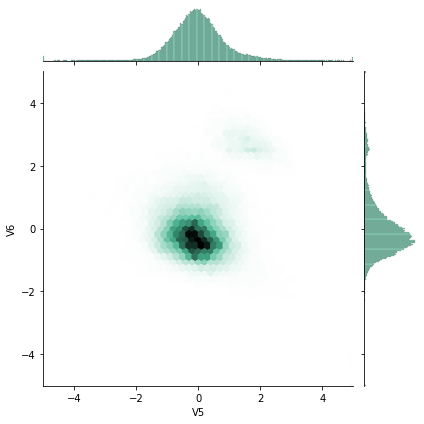

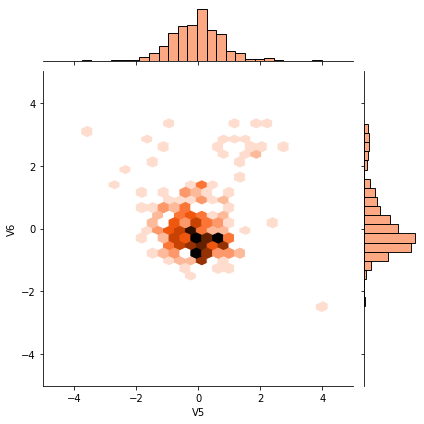

In [23]:
# create training dataframe
train_df = pd.DataFrame(data=X_train_Scaled, columns=X_train.columns)
train_df['Class'] = y_train

# check distribution using joint plot
sns.jointplot(x=train_df[(train_df.Class==0)]['V5'], y=train_df[(train_df.Class==0)]['V6'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#66c2a4');
sns.jointplot(x=train_df[(train_df.Class==1)]['V5'], y=train_df[(train_df.Class==1)]['V6'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#fc8d59');


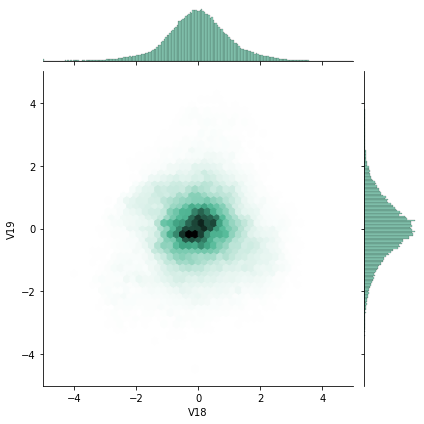

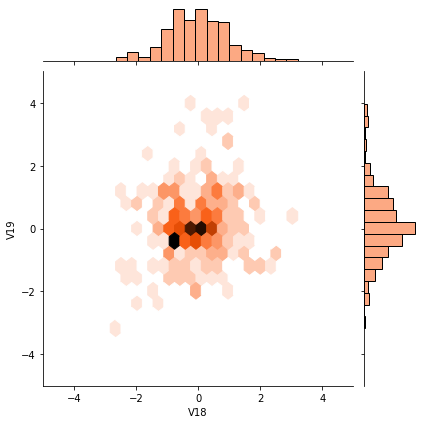

In [24]:
# check distribution using joint plot
sns.jointplot(x=train_df[(train_df.Class==0)]['V18'], y=train_df[(train_df.Class==0)]['V19'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#66c2a4');
sns.jointplot(x=train_df[(train_df.Class==1)]['V18'], y=train_df[(train_df.Class==1)]['V19'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#fc8d59');

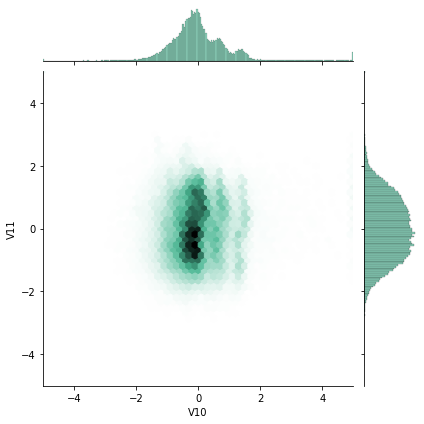

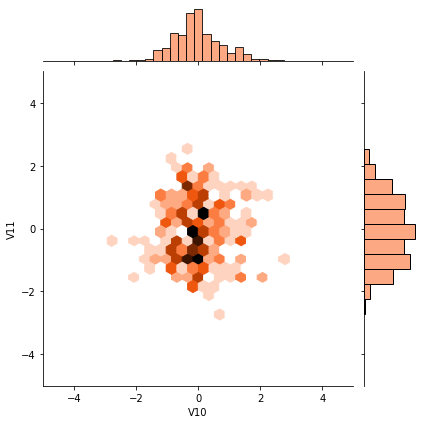

In [25]:
# check distribution using joint plot
sns.jointplot(x=train_df[(train_df.Class==0)]['V10'], y=train_df[(train_df.Class==0)]['V11'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#66c2a4');
sns.jointplot(x=train_df[(train_df.Class==1)]['V10'], y=train_df[(train_df.Class==1)]['V11'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#fc8d59');

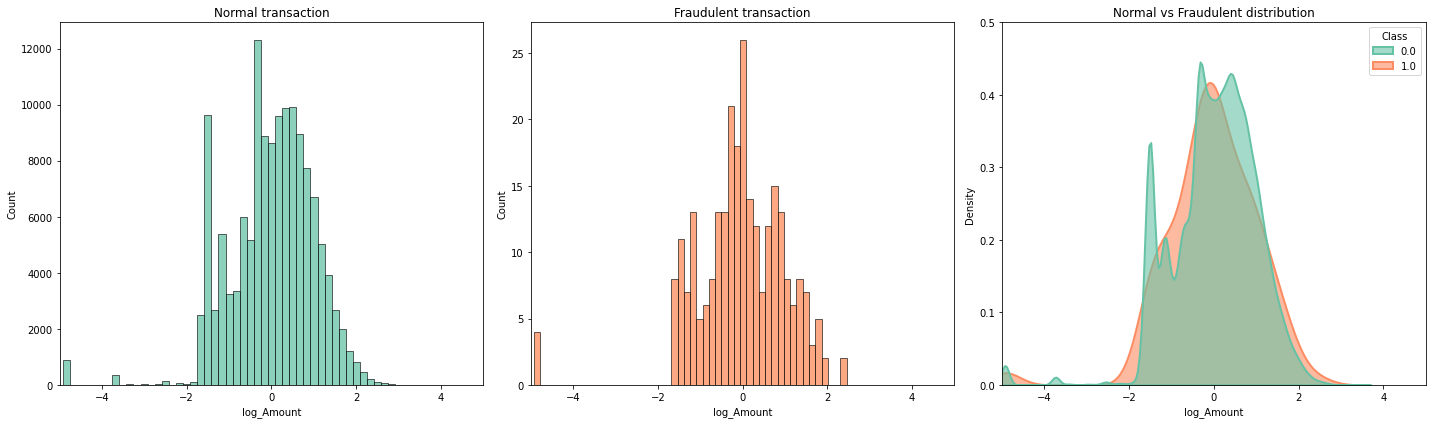

In [26]:
# check distribution of log_Amount
f, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.histplot(train_df[(train_df.Class==0)], x="log_Amount", bins=50, color='#66c2a4', ax=axs[0])
sns.histplot(train_df[(train_df.Class==1)], x="log_Amount", bins=50, color='#fc8d59', ax=axs[1])
sns.kdeplot(data=train_df, x="log_Amount", hue="Class",fill=True, common_norm=False, palette="Set2",alpha=.6, linewidth=2, ax=axs[2])
axs[0].set_title('Normal transaction')
axs[1].set_title('Fraudulent transaction')
axs[2].set_title('Normal vs Fraudulent distribution')
axs[0].set_xlim([-5,5])
axs[1].set_xlim([-5,5])
axs[2].set_xlim([-5,5])
axs[2].set_ylim([0,0.5])
f.tight_layout()

# Create Model

As stated before Accuracy won't be a good metric for Imbalanced dataset. Hence, lets explore some useful metrics.

1. Precision is the percentage of predicted positives that were correctly classified
2. Recall is the percentage of actual positives that were correctly classified
3. AUC refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC).


In [27]:
# import important packages
import keras
from keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, Precision, Recall, AUC, BinaryAccuracy
from keras.models import Model
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.initializers import Constant

In [28]:
# metrics to test
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc')
]

# create the logistic model
def logistic_model(units = 16, metrics = METRICS, output_bias=None):

  # create the model
  if output_bias is not None:
    output_bias = Constant(output_bias)
  i = Input(X_train_Scaled.shape[-1],)
  x = Dense(units, activation='relu')(i)
  x = Dropout(0.3)(x)
  x = Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)
  model = Model(i,x)
  
  # compile the model
  model.compile(
      optimizer=Adam(lr=1e-3),
      loss=BinaryCrossentropy(),
      metrics=metrics)

  return model

In [29]:
# call function
model = logistic_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


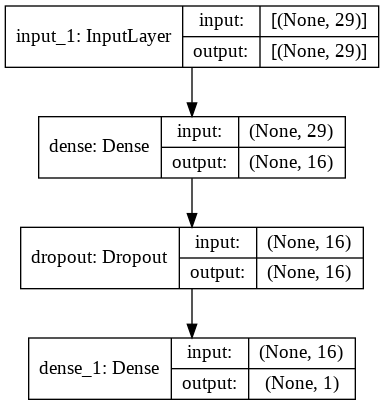

In [30]:
dot_img_file = 'model_1.png'
keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## First test the model without training

In [31]:
# Parameters
EPOCHS = 300
BATCH_SIZE = 2048

# model without training
results = model.evaluate(X_train_Scaled, y_train, verbose=1)
print("Loss:            {:0.2f}".format(results[0]))
print("True Positive:   {:0.2f}".format(results[1]))
print("False Positive:  {:0.2f}".format(results[2]))
print("True Negative:   {:0.2f}".format(results[3]))
print("False Negative:  {:0.2f}".format(results[4]))
print("Accuracy:        {:0.2f}".format(results[5]))
print("Precision:       {:0.2f}".format(results[6]))
print("Recall:          {:0.2f}".format(results[7]))
print("AUC:             {:0.2f}".format(results[8]))

6203/6203 [==============================] - 8s 1ms/step - loss: 0.2686 - tp: 44.3938 - fp: 1450.8317 - tn: 97661.3910 - fn: 123.3719 - accuracy: 0.9843 - precision: 0.0311 - recall: 0.2757 - auc: 0.7822
Loss:            0.27
True Positive:   90.00
False Positive:  2903.00
True Negative:   195232.00
False Negative:  251.00
Accuracy:        0.98
Precision:       0.03
Recall:          0.26
AUC:             0.77


## Passing the initial bias

In [32]:
# let's set teh initial bias so that model converges faaster during training
initial_bias = np.log([train_fraud/train_not_fraud])

# model with initial
model_bias = logistic_model(output_bias = initial_bias)
results_bias = model_bias.evaluate(X_train_Scaled, y_train, verbose=0)
print("Loss:            {:0.2f}".format(results_bias[0]))
print("True Positive:   {:0.2f}".format(results_bias[1]))
print("False Positive:  {:0.2f}".format(results_bias[2]))
print("True Negative:   {:0.2f}".format(results_bias[3]))
print("False Negative:  {:0.2f}".format(results_bias[4]))
print("Accuracy:        {:0.2f}".format(results_bias[5]))
print("Precision:       {:0.2f}".format(results_bias[6]))
print("Recall:          {:0.2f}".format(results_bias[7]))
print("AUC:             {:0.2f}".format(results_bias[8]))

Loss:            0.01
True Positive:   102.00
False Positive:  3202.00
True Negative:   393068.00
False Negative:  580.00
Accuracy:        0.99
Precision:       0.03
Recall:          0.15
AUC:             0.68


## Train Model With and Without Initial bias
Save model weights and start with re-training

In [33]:
import os
import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model_bias.save_weights(initial_weights)

Create new model and initialize weights

In [34]:
# new model
model_no_bias = logistic_model()

# load weight
model_no_bias.load_weights(initial_weights)

# initialize bias
model_no_bias.layers[-1].bias.assign([0.0])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

In [35]:
# Fit data to model with zero bias
zero_bias_history = model_no_bias.fit(
    X_train_Scaled,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid_Scaled, y_valid), 
    verbose=0)

In [36]:
# Test model without initial bias
results_no_bias = model_no_bias.evaluate(X_test_Scaled, y_test, verbose=0, batch_size=BATCH_SIZE)
print("Loss:            {:0.2f}".format(results_no_bias[0]))
print("True Positive:   {:0.2f}".format(results_no_bias[1]))
print("False Positive:  {:0.2f}".format(results_no_bias[2]))
print("True Negative:   {:0.2f}".format(results_no_bias[3]))
print("False Negative:  {:0.2f}".format(results_no_bias[4]))
print("Accuracy:        {:0.2f}".format(results_no_bias[5]))
print("Precision:       {:0.2f}".format(results_no_bias[6]))
print("Recall:          {:0.2f}".format(results_no_bias[7]))
print("AUC:             {:0.2f}".format(results_no_bias[8]))

Loss:            0.01
True Positive:   36.00
False Positive:  1.00
True Negative:   27519.00
False Negative:  11.00
Accuracy:        1.00
Precision:       0.97
Recall:          0.77
AUC:             0.93


In [37]:
# Fit data to model with initial bias
model_with_initial_bias = logistic_model()
model_with_initial_bias.load_weights(initial_weights)
initial_bias_history = model_with_initial_bias.fit(
    X_train_Scaled,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid_Scaled, y_valid), 
    verbose=0)

In [38]:
# Test model with initial bias
results_with_initial_bias = model_with_initial_bias.evaluate(X_test_Scaled, y_test, verbose=0, batch_size=BATCH_SIZE)
print("Loss:            {:0.2f}".format(results_with_initial_bias[0]))
print("True Positive:   {:0.2f}".format(results_with_initial_bias[1]))
print("False Positive:  {:0.2f}".format(results_with_initial_bias[2]))
print("True Negative:   {:0.2f}".format(results_with_initial_bias[3]))
print("False Negative:  {:0.2f}".format(results_with_initial_bias[4]))
print("Accuracy:        {:0.2f}".format(results_with_initial_bias[5]))
print("Precision:       {:0.2f}".format(results_with_initial_bias[6]))
print("Recall:          {:0.2f}".format(results_with_initial_bias[7]))
print("AUC:             {:0.2f}".format(results_with_initial_bias[8]))

Loss:            0.01
True Positive:   36.00
False Positive:  4.00
True Negative:   27516.00
False Negative:  11.00
Accuracy:        1.00
Precision:       0.90
Recall:          0.77
AUC:             0.90


## Early Stopping, Plot functions and confusion metrics


In [39]:
import matplotlib as mpl

# Customize our Matplot lib visualization figure size and colors
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# define function to generate loss plot
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

# function to plot all metrics for training and validation data
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    # subplots() which acts as a utility wrapper and helps in creating common layouts of subplots
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

# confusion metrics
from sklearn.metrics import confusion_matrix
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

# ROC curves
import sklearn
def plot_roc(name, labels, predictions, **kwargs):
  # Plot Receiver operating characteristic (ROC) curve.
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

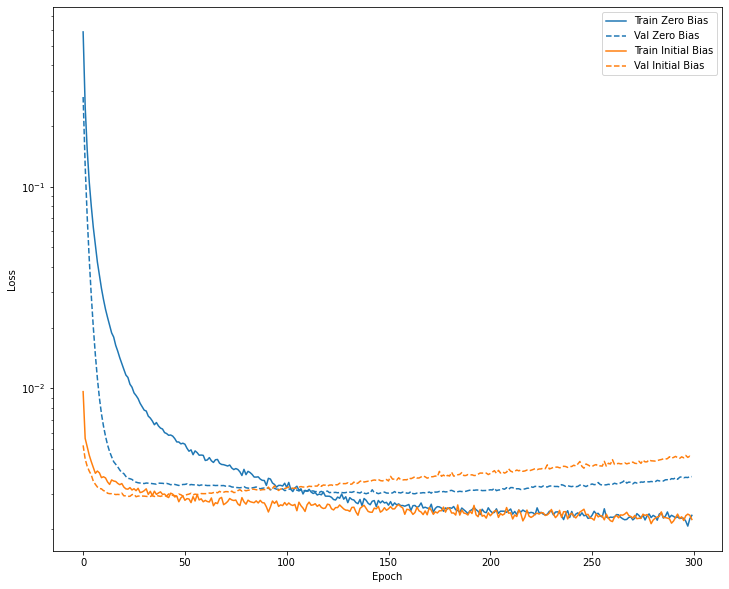

In [40]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(initial_bias_history, "Initial Bias", 1)

Add early stopping as we can see after initial bias as number of epochs increases the training and validation looss is also increaing which may result from overfitting.

Early stopping is equivalent to L2 regularization

In [41]:
# Stop training when a monitored metric has stopped improving.
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=50,
    mode='max',
    restore_best_weights=True)

## Basline Model

Train basline model with early stopping

In [42]:
baseline_model = logistic_model()
baseline_model.load_weights(initial_weights)
# Fit data to model
baseline_history = baseline_model.fit(
    X_train_Scaled,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_valid_Scaled, y_valid),
    verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping


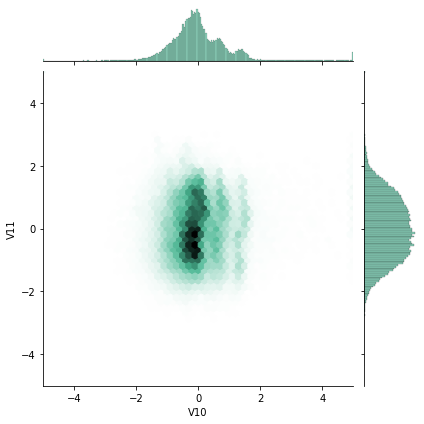

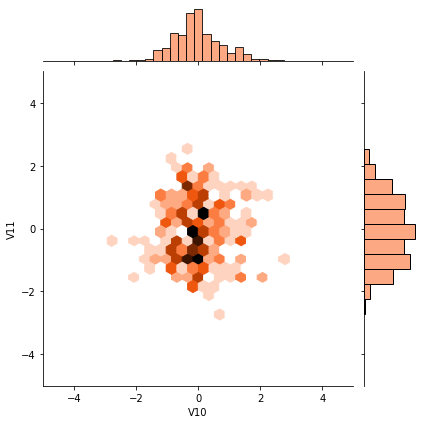

In [43]:
baseline_df = pd.DataFrame(data=X_train_Scaled, columns=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'log_Amount'])
baseline_df['Class'] = y_train
# check distribution using joint plot
sns.jointplot(x=baseline_df[(baseline_df['Class'] == 0)]['V10'], y=baseline_df[(baseline_df['Class'] == 0)]['V11'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#66c2a4');
sns.jointplot(x=baseline_df[(baseline_df['Class'] == 1)]['V10'], y=baseline_df[(baseline_df['Class'] == 1)]['V11'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#fc8d59');


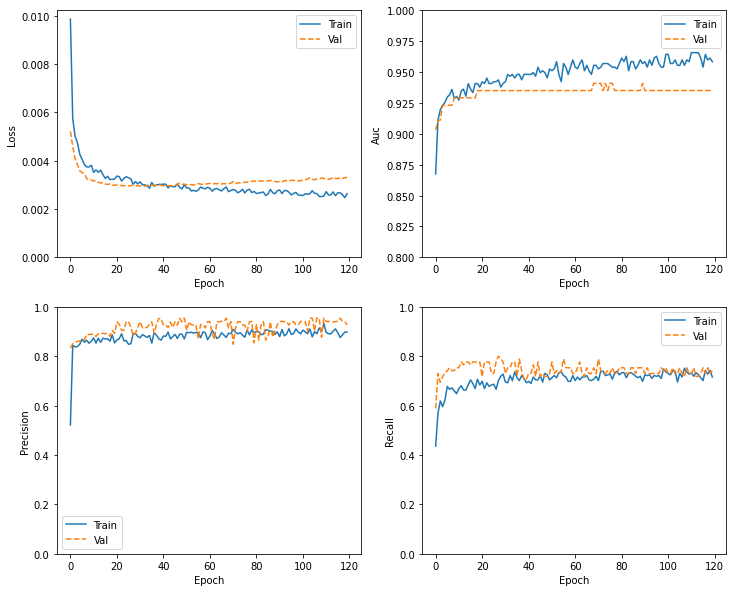

In [44]:
# plot metrics
plot_metrics(baseline_history)

loss :  0.003528494853526354
tp :  35.0
fp :  2.0
tn :  27518.0
fn :  12.0
accuracy :  0.9994921684265137
precision :  0.9459459185600281
recall :  0.7446808218955994
auc :  0.9145295023918152

Legitimate Transactions Detected (True Negatives):  27518
Legitimate Transactions Incorrectly Detected (False Positives):  2
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  35
Total Fraudulent Transactions:  47


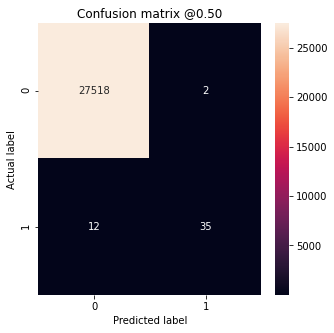

In [45]:
train_predictions_baseline = baseline_model.predict(X_train_Scaled, batch_size=BATCH_SIZE)
valid_predictions_baseline = baseline_model.predict(X_valid_Scaled, batch_size=BATCH_SIZE)
test_predictions_baseline = baseline_model.predict(X_test_Scaled, batch_size=BATCH_SIZE)
baseline_results = baseline_model.evaluate(X_test_Scaled, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

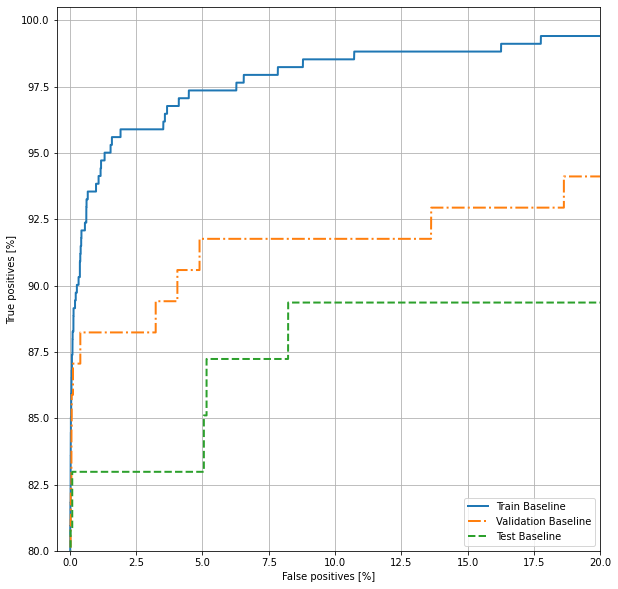

In [46]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Validation Baseline", y_valid, valid_predictions_baseline, color=colors[1], linestyle='-.')
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

## Class weights
Penalizing model when not predicting the minoritoy class more compared to majority class

In [47]:
weight_for_0 = (1 / train_not_fraud)*(train_total)/2.0 
weight_for_1 = (1 / train_fraud)*(train_total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 291.02


In [48]:
# trainn model
weighted_model = logistic_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train_Scaled,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_valid_Scaled, y_valid),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/300
97/97 [==============================] - 3s 17ms/step - loss: 1.2856 - tp: 117.1327 - fp: 397.2143 - tn: 128303.0000 - fn: 101.0816 - accuracy: 0.9965 - precision: 0.2647 - recall: 0.5219 - auc: 0.8837 - val_loss: 0.0178 - val_tp: 68.0000 - val_fp: 154.0000 - val_tn: 49381.0000 - val_fn: 17.0000 - val_accuracy: 0.9966 - val_precision: 0.3063 - val_recall: 0.8000 - val_auc: 0.9341
Epoch 2/300
97/97 [==============================] - 1s 8ms/step - loss: 0.5286 - tp: 136.7449 - fp: 685.3469 - tn: 100488.6735 - fn: 40.6633 - accuracy: 0.9931 - precision: 0.1706 - recall: 0.7687 - auc: 0.9259 - val_loss: 0.0248 - val_tp: 69.0000 - val_fp: 227.0000 - val_tn: 49308.0000 - val_fn: 16.0000 - val_accuracy: 0.9951 - val_precision: 0.2331 - val_recall: 0.8118 - val_auc: 0.9457
Epoch 3/300
97/97 [==============================] - 1s 8ms/step - loss: 0.3731 - tp: 140.6531 - fp: 1088.6429 - tn: 100091.2959 - fn: 30.8367 - accuracy: 0.9890 - precision: 0.1148 - recall: 0.8179 - auc: 0.9488

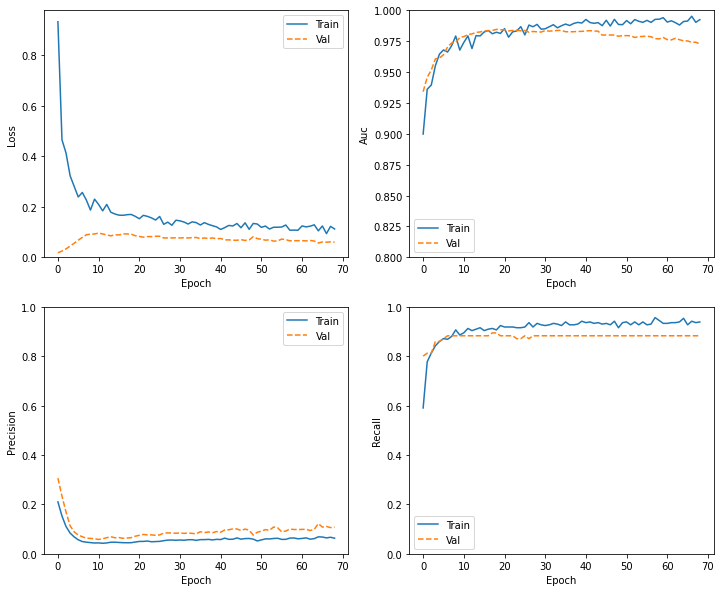

In [49]:
plot_metrics(weighted_history)

In [50]:
# nake prediction for train and test
train_predictions_weighted = weighted_model.predict(X_train_Scaled, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test_Scaled, batch_size=BATCH_SIZE)

loss :  0.08992382138967514
tp :  40.0
fp :  596.0
tn :  26924.0
fn :  7.0
accuracy :  0.978126049041748
precision :  0.0628930851817131
recall :  0.8510638475418091
auc :  0.9721007943153381

Legitimate Transactions Detected (True Negatives):  26924
Legitimate Transactions Incorrectly Detected (False Positives):  596
Fraudulent Transactions Missed (False Negatives):  7
Fraudulent Transactions Detected (True Positives):  40
Total Fraudulent Transactions:  47


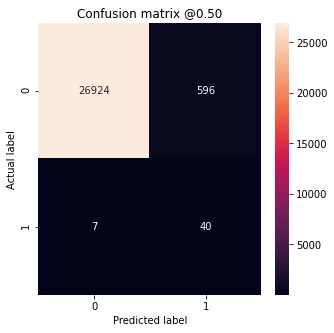

In [51]:
# genarate confusion metrics
weighted_results = weighted_model.evaluate(X_test_Scaled, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

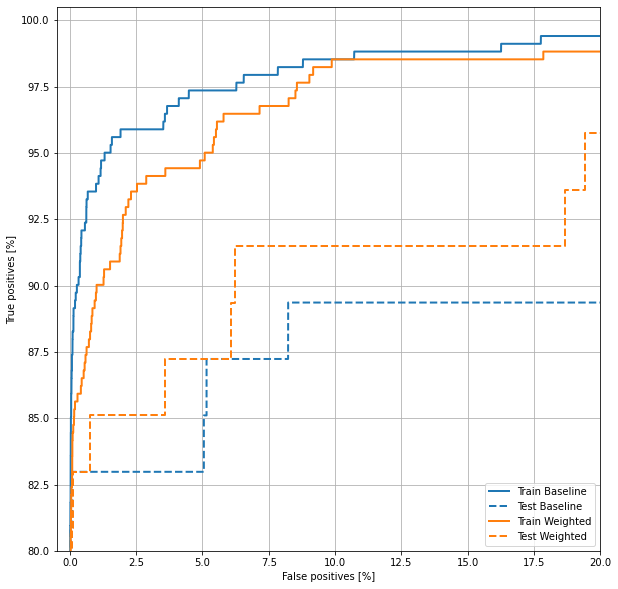

In [52]:
# generate roc curve
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


# Function legend() which is used to Place a legend on the axes
plt.legend(loc='lower right')

## Oversampling - Duplicates

In [53]:
# sepreting fraud and non-fraud data
bool_train_labels = y_train != 0

# creating seperate features
pos_features = X_train_Scaled[bool_train_labels]
neg_features = X_train_Scaled[~bool_train_labels]

# seperate labels
pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

# getting id's of positive cases
ids = np.arange(len(pos_features))

# randomly choosing ids and making it to the size of non-fraud
choices = np.random.choice(ids, len(neg_features))

# generating data
res_pos_features = pos_features[choices]
res_pos_labels = pos_labels.iloc[choices]

In [54]:
# create a balanced dataset using positive and negative cases
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

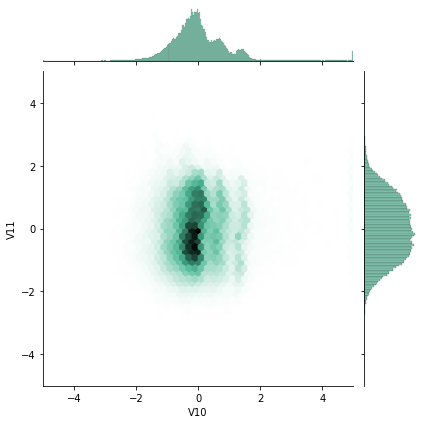

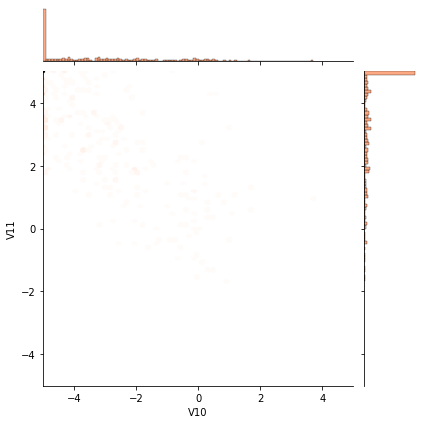

In [55]:
over_df = pd.DataFrame(data=resampled_features, columns=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'log_Amount'])
over_df['Class'] = resampled_labels
# check distribution using joint plot
sns.jointplot(x=over_df[(over_df['Class'] == 0)]['V10'], y=over_df[(over_df['Class'] == 0)]['V11'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#66c2a4');
sns.jointplot(x=over_df[(over_df['Class'] == 1)]['V10'], y=over_df[(over_df['Class'] == 1)]['V11'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#fc8d59');


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


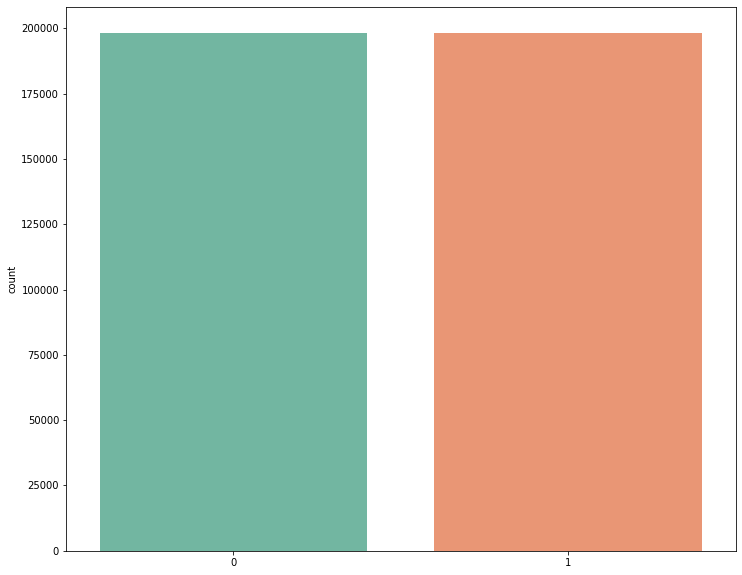

In [56]:
# plot see the new dataset
sns.countplot(resampled_labels, palette='Set2')

In [57]:
# pass balanced data to model
resampled_model = logistic_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_valid_Scaled, y_valid),
    verbose=1)

Epoch 1/300
194/194 [==============================] - 4s 11ms/step - loss: 0.4906 - tp: 89381.1026 - fp: 32679.8769 - tn: 95299.0769 - fn: 10889.7538 - accuracy: 0.8045 - precision: 0.6981 - recall: 0.8791 - auc: 0.9221 - val_loss: 0.2511 - val_tp: 75.0000 - val_fp: 1632.0000 - val_tn: 47903.0000 - val_fn: 10.0000 - val_accuracy: 0.9669 - val_precision: 0.0439 - val_recall: 0.8824 - val_auc: 0.9608
Epoch 2/300
194/194 [==============================] - 1s 7ms/step - loss: 0.2128 - tp: 91887.7077 - fp: 6745.2974 - tn: 93633.1128 - fn: 8416.6923 - accuracy: 0.9222 - precision: 0.9283 - recall: 0.9149 - auc: 0.9701 - val_loss: 0.1457 - val_tp: 75.0000 - val_fp: 950.0000 - val_tn: 48585.0000 - val_fn: 10.0000 - val_accuracy: 0.9807 - val_precision: 0.0732 - val_recall: 0.8824 - val_auc: 0.9706
Epoch 3/300
194/194 [==============================] - 1s 7ms/step - loss: 0.1591 - tp: 93269.1128 - fp: 4244.8821 - tn: 96108.3897 - fn: 7060.4256 - accuracy: 0.9428 - precision: 0.9555 - recall: 0

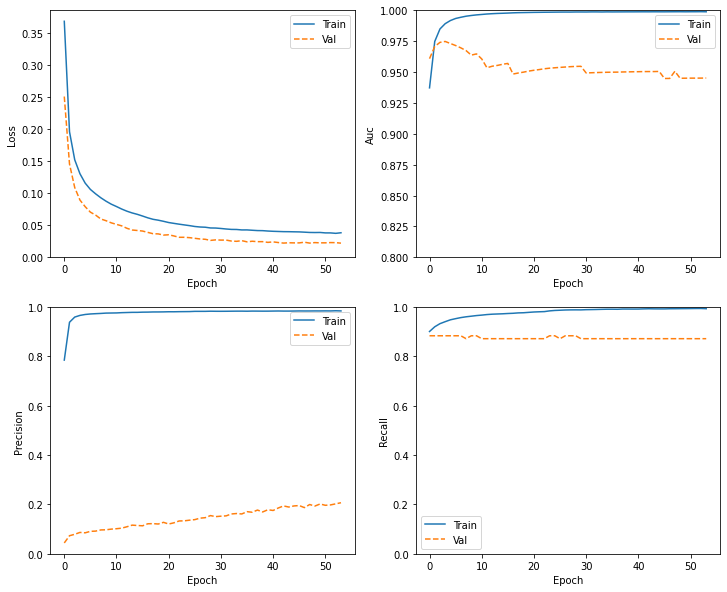

In [58]:
plot_metrics(resampled_history )

loss :  0.0889856368303299
tp :  39.0
fp :  451.0
tn :  27069.0
fn :  8.0
accuracy :  0.9833496809005737
precision :  0.07959183305501938
recall :  0.8297872543334961
auc :  0.9646667242050171

Legitimate Transactions Detected (True Negatives):  27069
Legitimate Transactions Incorrectly Detected (False Positives):  451
Fraudulent Transactions Missed (False Negatives):  8
Fraudulent Transactions Detected (True Positives):  39
Total Fraudulent Transactions:  47


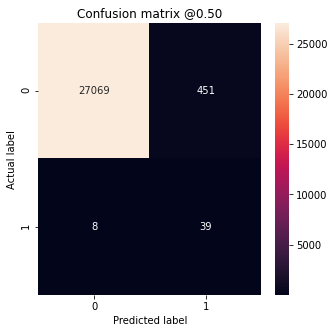

In [59]:
# generate confusion metrics
train_predictions_resampled = resampled_model.predict(X_train_Scaled, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_test_Scaled, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(X_test_Scaled, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_resampled)

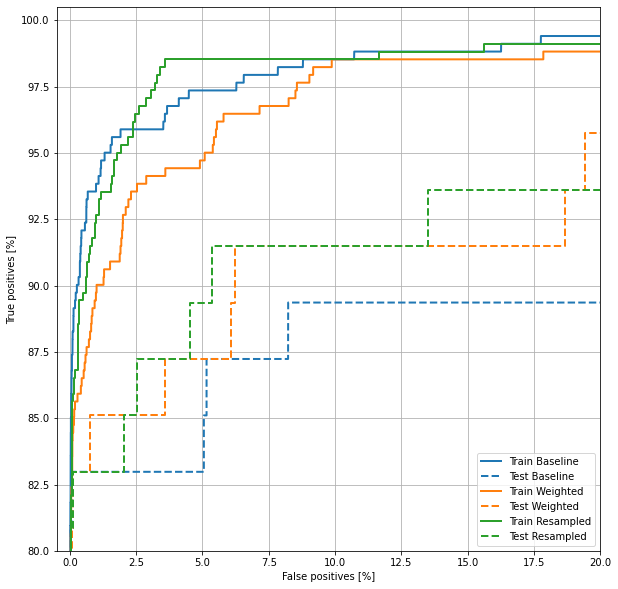

In [60]:
# compare ROC curve
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", y_train, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", y_test, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')

## Oversampling - SMOTE

In [61]:
from imblearn.over_sampling import SVMSMOTE

#create synthesized data
smote_object = SVMSMOTE(random_state=0)
data_X,data_y = smote_object.fit_sample(X_train_Scaled, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


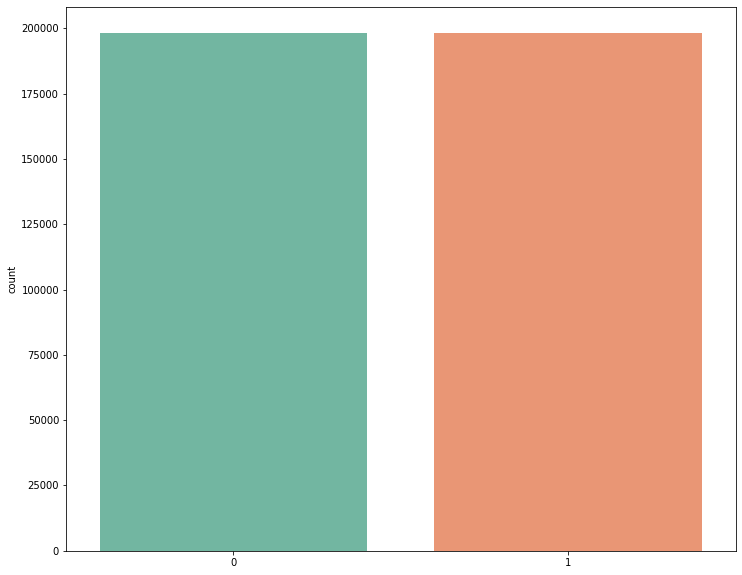

In [62]:
# plot see the new dataset
sns.countplot(data_y, palette='Set2')

In [63]:
# generate model with balanced data with SMOTE
smote_model = logistic_model()
smote_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = smote_model.layers[-1] 
output_layer.bias.assign([0])

smote_history = smote_model.fit(
    data_X,
    data_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS*2,
    callbacks = [early_stopping],
    validation_data=(X_valid_Scaled, y_valid),
    verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping


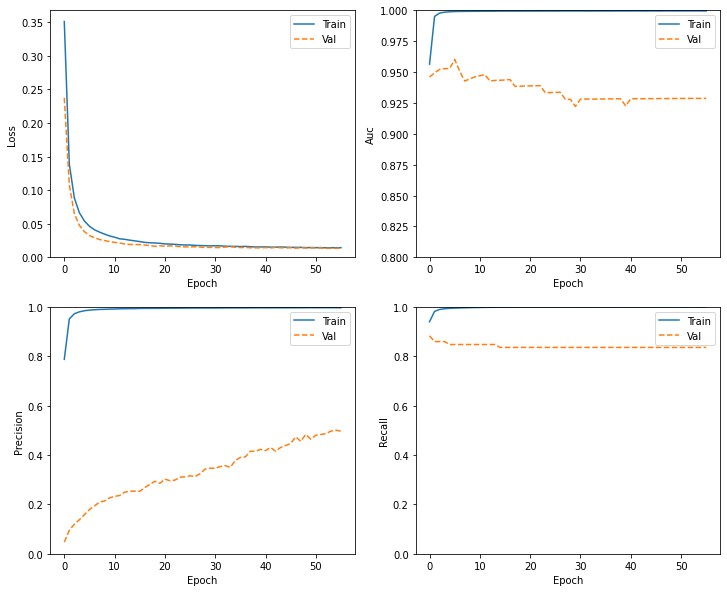

In [64]:
plot_metrics(smote_history )

In [80]:
X_train_Scaled.shape

(198476, 29)

loss :  0.031115880236029625
tp :  39.0
fp :  178.0
tn :  27342.0
fn :  8.0
accuracy :  0.9932528138160706
precision :  0.17972350120544434
recall :  0.8297872543334961
auc :  0.9479759335517883

Legitimate Transactions Detected (True Negatives):  27342
Legitimate Transactions Incorrectly Detected (False Positives):  178
Fraudulent Transactions Missed (False Negatives):  8
Fraudulent Transactions Detected (True Positives):  39
Total Fraudulent Transactions:  47


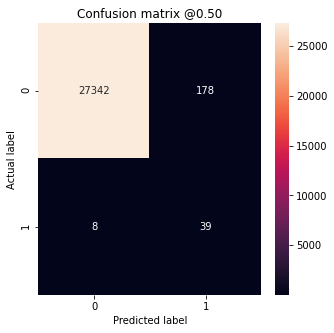

In [81]:
# generate confusion metrics
train_predictions_smote = smote_model.predict(data_X, batch_size=BATCH_SIZE)
test_predictions_smote = smote_model.predict(X_test_Scaled, batch_size=BATCH_SIZE)

smote_results = smote_model.evaluate(X_test_Scaled, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(smote_model.metrics_names, smote_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_smote)

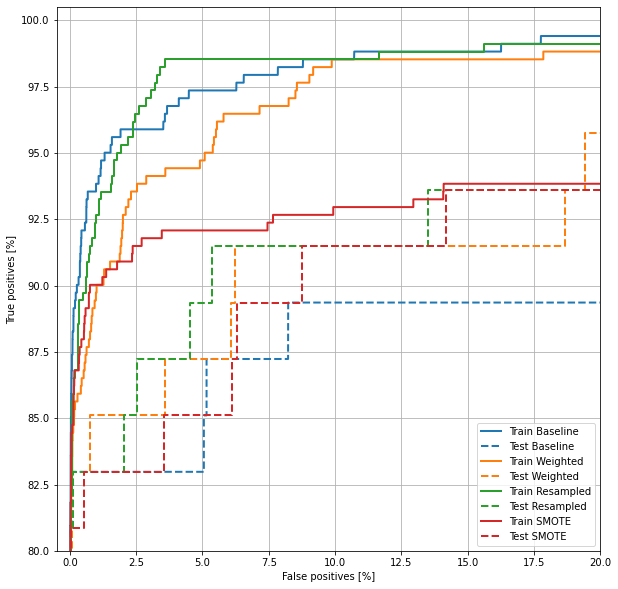

In [66]:
# compare
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", y_train, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", y_test, test_predictions_resampled,  color=colors[2], linestyle='--')

plot_roc("Train SMOTE", y_train, train_predictions_smote,  color=colors[3])
plot_roc("Test SMOTE", y_test, test_predictions_smote,  color=colors[3], linestyle='--')

plt.legend(loc='lower right')

## Undersmapling

In [67]:
# Undersmapling the majority class in this case non-fraudlent data
ids = np.arange(len(neg_features))
# randomly choosing ids
choices = np.random.choice(ids, len(pos_features))
# generating data equal to positive class
res_neg_features = neg_features[choices]
res_neg_labels = neg_labels.iloc[choices]

# concatenate negative and positive class
undersampled_features = np.concatenate([res_neg_features, pos_features], axis=0)
undersampled_labels = np.concatenate([res_neg_labels, pos_labels], axis=0)

order = np.arange(len(undersampled_labels))
np.random.shuffle(order)
undersampled_features = undersampled_features[order]
undersampled_labels = undersampled_labels[order]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


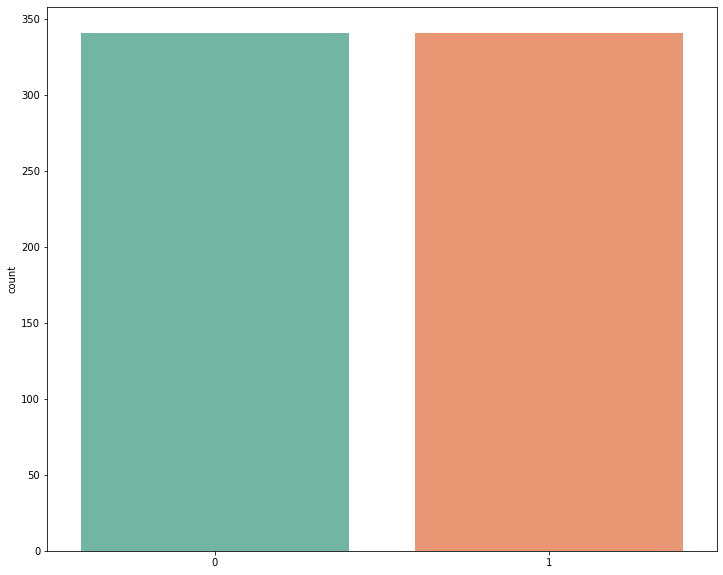

In [68]:
# plot see the new dataset
sns.countplot(undersampled_labels, palette='Set2')

In [69]:
# create model
undersampled_model = logistic_model()
undersampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = undersampled_model.layers[-1] 
output_layer.bias.assign([0])

undersampled_history = undersampled_model.fit(
    undersampled_features,
    undersampled_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS*10,
    callbacks = [early_stopping],
    validation_data=(X_valid_Scaled, y_valid),
    verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00518: early stopping


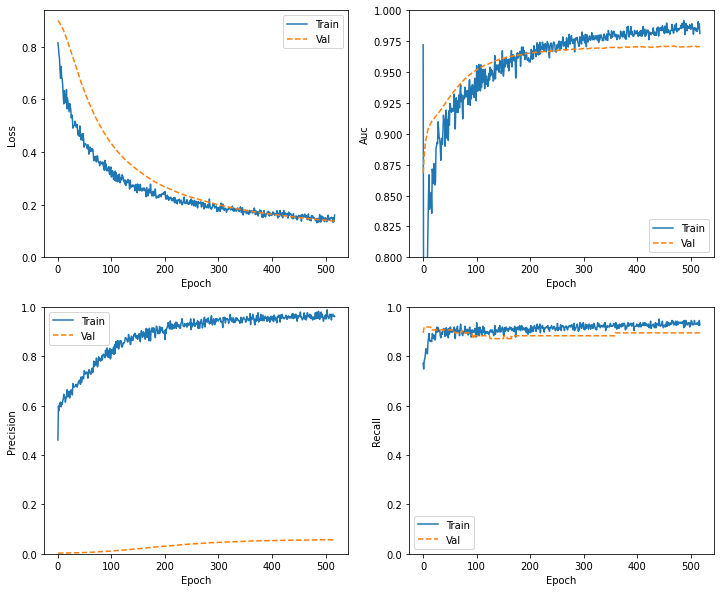

In [70]:
plot_metrics(undersampled_history)

loss :  0.14624612033367157
tp :  39.0
fp :  698.0
tn :  26822.0
fn :  8.0
accuracy :  0.9743896722793579
precision :  0.0529172308743
recall :  0.8297872543334961
auc :  0.9589381814002991

Legitimate Transactions Detected (True Negatives):  26822
Legitimate Transactions Incorrectly Detected (False Positives):  698
Fraudulent Transactions Missed (False Negatives):  8
Fraudulent Transactions Detected (True Positives):  39
Total Fraudulent Transactions:  47


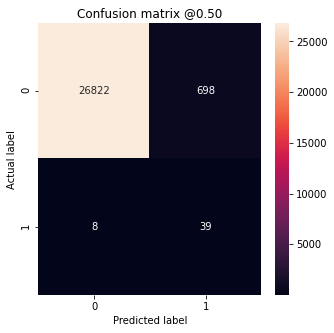

In [71]:
# generate confusion metrics
train_predictions_undersampled = undersampled_model.predict(X_train_Scaled, batch_size=BATCH_SIZE)
test_predictions_undersampled = undersampled_model.predict(X_test_Scaled, batch_size=BATCH_SIZE)

undersampled_results = undersampled_model.evaluate(X_test_Scaled, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(undersampled_model.metrics_names, undersampled_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_undersampled)

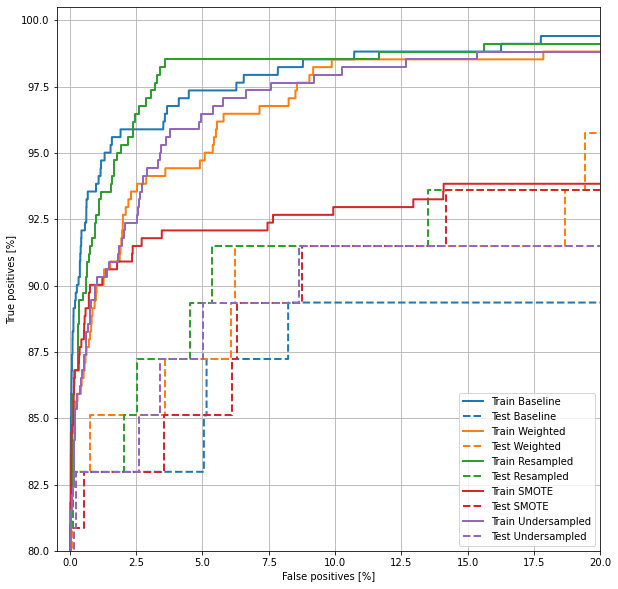

In [72]:
# comapre
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", y_train, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", y_test, test_predictions_resampled,  color=colors[2], linestyle='--')

plot_roc("Train SMOTE", y_train, train_predictions_smote,  color=colors[3])
plot_roc("Test SMOTE", y_test, test_predictions_smote,  color=colors[3], linestyle='--')

plot_roc("Train Undersampled", y_train, train_predictions_undersampled,  color=colors[4])
plot_roc("Test Undersampled", y_test, test_predictions_undersampled,  color=colors[4], linestyle='--')

plt.legend(loc='lower right')